In [1]:
import pandas as pd
import os

In [2]:
data_url = "/Users/benjaminzaidel/Desktop/Kaggle/Forex_Pairs"

In [3]:
import os
import pandas as pd

def create_wide_dataframe(data_folder: str, limit_rows: int = None) -> pd.DataFrame:
    """
    Reads all .txt files in `data_folder`, each containing
    <DTYYYYMMDD>, <TIME>, <CLOSE>, etc. The resulting DataFrame
    has:
      - A 'time_step' column (int) formed by concatenating date/time (YYYYMMDDHHMMSS).
      - One column per currency pair (derived from filename).
      - Each cell is the <CLOSE> value for that (time_step, currency_pair).
    
    Only reads up to `limit_rows` from each file (if provided).

    Then sorts rows by the first 8 digits of time_step (date),
    and then by the remaining digits (time).
    """

    dfs_for_merge = []

    for filename in os.listdir(data_folder):
        if filename.endswith(".txt"):
            filepath = os.path.join(data_folder, filename)
            
            # 1) Optionally limit rows
            if limit_rows is not None:
                df = pd.read_csv(filepath, nrows=limit_rows)
            else:
                df = pd.read_csv(filepath)

            required_cols = {"<DTYYYYMMDD>", "<TIME>", "<CLOSE>"}
            if not required_cols.issubset(df.columns):
                print(f"Warning: Missing required columns in '{filename}'. Skipping.")
                continue

            df["time_step"] = (
                df["<DTYYYYMMDD>"].astype(str) + df["<TIME>"].astype(str)
            ).astype(int)
            
            currency_pair = os.path.splitext(filename)[0]  # e.g. 'AUDJPY.txt' -> 'AUDJPY'

            mini_df = df[["time_step", "<CLOSE>"]].copy()
            mini_df.rename(columns={"<CLOSE>": currency_pair}, inplace=True)
            mini_df.set_index("time_step", inplace=True)

            dfs_for_merge.append(mini_df)

    if not dfs_for_merge:
        print("No valid data found or missing required columns.")
        return pd.DataFrame(columns=["time_step"])

    # 2) Merge all mini DataFrames side-by-side on time_step
    df_wide = pd.concat(dfs_for_merge, axis=1)

    df_wide.reset_index(inplace=True)

    # 3) Sort by date/time
    time_str = df_wide["time_step"].astype(str)
    date_part = time_str.str[:8].astype(int)
    time_part = time_str.str[8:].astype(int)

    df_wide["date_part"] = date_part
    df_wide["time_part"] = time_part

    df_wide.sort_values(by=["date_part", "time_part"], inplace=True, ascending=[True, True])
    df_wide.drop(["date_part", "time_part"], axis=1, inplace=True)

    return df_wide


In [4]:
from typing import List, Tuple
import numpy as np
def build_rate_matrices(df_wide: pd.DataFrame) -> Tuple[List[np.ndarray], List[int]]:
    """
    Convert each row of the wide df into an adjacency matrix.
    Returns a list of matrices (one per row) and
    the corresponding list of time_steps for reference.
    """
    # 1) Identify all currency pairs
    all_pairs = [col for col in df_wide.columns if col != "time_step"]
    
    # 2) Extract unique currencies
    currency_set = set()
    for pair in all_pairs:
        base = pair[:3]
        quote = pair[3:]
        currency_set.add(base)
        currency_set.add(quote)
    currency_list = sorted(list(currency_set))
    currency_to_idx = {cur: i for i, cur in enumerate(currency_list)}
    
    # 3) We'll build a list of adjacency matrices, one per row
    rate_matrices = []
    time_steps = []

    for _, row in df_wide.iterrows():
        # Initialize adjacency
        n_c = len(currency_list)
        mat = np.zeros((n_c, n_c), dtype=np.float32)
        # set diagonal to 1.0
        np.fill_diagonal(mat, 1.0)
        
        for pair in all_pairs:
            rate = row[pair]
            if pd.isna(rate):
                continue
            base = pair[:3]
            quote = pair[3:]
            
            i = currency_to_idx[base]
            j = currency_to_idx[quote]
            
            mat[i, j] = rate
            
            # if you also want to fill the reciprocal:
            if rate > 0:
                mat[i, j] = rate
                mat[j, i] = 1 / rate
            else:
                mat[i, j] = 0
                mat[j, i] = 0

        
        
        rate_matrices.append(mat)
        time_steps.append(row["time_step"])
    
    return rate_matrices, time_steps, currency_list


In [28]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces

class ForexTradingEnv(gym.Env):
    def __init__(self, rate_matrices, currency_list, base_currency='USD',
                 max_steps_per_episode=1000):
        super().__init__()
        
        self.rate_matrices = rate_matrices
        self.currency_list = currency_list
        self.n_c = len(currency_list)
        self.base_idx = currency_list.index(base_currency)
        
        self.num_steps = len(rate_matrices)
        self.max_steps_per_episode = max_steps_per_episode
        
        # Portfolio
        self.portfolio = np.zeros(self.n_c, dtype=np.float32)
        
        # Action space: choose i->j among n_c*n_c
        self.action_space = spaces.Discrete(self.n_c * self.n_c)
        
        # Observation space: (n_c, n_c) adjacency matrix
        self.observation_space = spaces.Box(
            low=0, high=np.inf,
            shape=(self.n_c, self.n_c),
            dtype=np.float32
        )
        
        # For random window logic
        self.current_step = 0
        self.start_index = 0
        self.end_index = 0

    def reset(self, *, seed=None, options=None):
        """
        Randomly pick a start index for each episode,
        so we don't always begin at step=0.
        """
        super().reset(seed=seed)
        
        # Random start: ensures we can sample different windows
        if self.num_steps > self.max_steps_per_episode:
            self.start_index = np.random.randint(
                0, 
                self.num_steps - self.max_steps_per_episode
            )
        else:
            # If dataset is smaller than max_steps_per_episode, just start at 0
            self.start_index = 0
        
        self.end_index = self.start_index + self.max_steps_per_episode
        self.current_step = self.start_index
        
        # Reset portfolio
        self.portfolio[:] = 0.0
        self.portfolio[self.base_idx] = 1.0
        
        obs = self._get_obs()
        info = {}
        return obs, info

    def step(self, action):
        i = action // self.n_c
        j = action % self.n_c
        
        # 1) Get the base (original) matrix for this step
        base_matrix = self.rate_matrices[self.current_step]
        
        # 2) Copy it so we don’t overwrite the original data
        current_matrix = base_matrix.copy()
        
        # 3) Inject noise as a single factor for the entire matrix
        eps = np.random.normal(loc=0.0, scale=0.01)  # one random draw
        factor = np.exp(eps)                         # multiplicative factor
        current_matrix *= factor                     # scale all rates by 'factor'
        
        # 4) Compute old base-currency value
        old_val_base = self._value_in_base(current_matrix)
        
        # (Optional) small penalty for no-trade or invalid trades
        # no_trade_penalty = -0.00001 if (i == j or current_matrix[i, j] == 0) else 0.0

        print(f"BEFORE trade: step={self.current_step}, i={i}, j={j}, old_val={old_val_base:.4f}, portfolio={self.portfolio}")
        
        # 5) Perform currency conversion if valid
        if i != j and current_matrix[i, j] > 0:
            amount_i = self.portfolio[i]
            if amount_i > 0:
                self.portfolio[i] = 0.0
                self.portfolio[j] += amount_i * current_matrix[i, j]
        
        # 6) Advance time
        self.current_step += 1
        
        # 7) Check termination
        terminated = (self.current_step >= self.end_index) or (self.current_step >= self.num_steps)
        truncated = False
        
        if terminated:
            # Final reward: final base value - 1.0
            final_val_base = self._value_in_base(current_matrix)
            reward = final_val_base - 1.0
            obs = self.rate_matrices[-1]  # A valid final obs
            print(f"[DONE] final_val={final_val_base:.4f}, reward={reward:.4f}")
        else:
            # Step reward = delta in base currency from old to new
            # Note: we do NOT re-apply noise to new_matrix here, unless you want each step to differ
            new_matrix = self.rate_matrices[self.current_step]
            new_val_base = self._value_in_base(new_matrix)
            reward = new_val_base - old_val_base
            # reward += no_trade_penalty  # if using a penalty
            print(f"AFTER trade: step={self.current_step}, new_val={new_val_base:.4f}, reward={reward:.4f}, portfolio={self.portfolio}")
            
            obs = self.rate_matrices[self.current_step]
        
        info = {}
        return obs, reward, terminated, truncated, info


    def _get_obs(self):
        return self.rate_matrices[self.current_step]

    def _value_in_base(self, matrix):
        total_base = 0.0
        for c_idx, amt in enumerate(self.portfolio):
            if c_idx == self.base_idx:
                total_base += amt
            else:
                rate = matrix[c_idx, self.base_idx]
                if rate > 0:
                    total_base += amt * rate
        return total_base


Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.802    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1237     |
|    time_elapsed     | 16       |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0622   |
|    n_updates        | 4974     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.604    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1168     |
|    time_elapsed     | 34       |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0285   |
|    n_updates        | 9974     |
----------------------------------
----------------------------------
| rollout/            |          |
|  

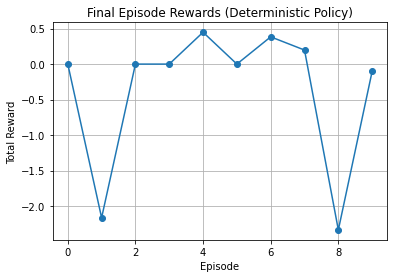

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv


# 1) Create the wide DataFrame
df_wide = create_wide_dataframe(data_url, limit_rows = 5000000)

# Optionally limit to the first 1000 rows for faster experiments:
#df_wide = df_wide.head(1000).copy()

# 2) Convert df_wide to adjacency matrices
rate_matrices, time_steps, currency_list = build_rate_matrices(df_wide)

# Suppose you already built df_wide, rate_matrices, time_steps, currency_list
# from your code above. Now create the environment:

env_instance = ForexTradingEnv(
    rate_matrices,
    currency_list,
    base_currency='USD',
    max_steps_per_episode=5000  # or 2000, etc.
)

env = DummyVecEnv([lambda: env_instance])

model = DQN(
    policy="MlpPolicy",
    env=env,
    learning_rate=1e-4,               # Lower LR for possibly more stable training
    buffer_size=200000,               # Larger replay buffer
    batch_size=64,                   # Larger batch size
    exploration_fraction=0.2,         # Explore more for longer
    exploration_final_eps=0.01,       # End with lower epsilon
    policy_kwargs={"net_arch": [256, 256]},  # Bigger network
    verbose=1
)

# Increase total timesteps so it sees many episodes
model.learn(total_timesteps=500000)  # half a million steps



Episode Rewards: [0.0, 0.0, -1.041623830795288, 0.0, 0.0, 0.0, -0.22403597831726074, -2.9047588109970093, -0.367145836353302, 0.0, -2.0736523270606995, 0.0, 0.02200084924697876, -2.097860813140869, 0.0, 0.0, 0.0, 0.0, 0.09970313310623169, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.24501317739486694, 0.0, -1.33209890127182, 0.05197548866271973, 0.0, 0.0, 0.0, 0.0, -2.0917325615882874, -0.6179355382919312, -1.989855706691742, 0.0, 0.0, -0.7950120568275452, 1.2488612532615662, 0.0, -0.37814146280288696, -0.04206192493438721, 0.0, 0.0, -1.8966822624206543, 0.0, 0.5512920618057251, 0.0, -0.23369503021240234, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10011780261993408, -2.053790807723999, 0.0, -0.02820122241973877, 0.05813467502593994, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.9305250644683838, 0.0, 0.0, 0.0, -1.7617756128311157, 0.0, 0.0, 0.0, -0.18391716480255127, -1.7428236603736877, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.39257901906967163, 0.10771673917770386, -1.8571409583091736, -2.402444303

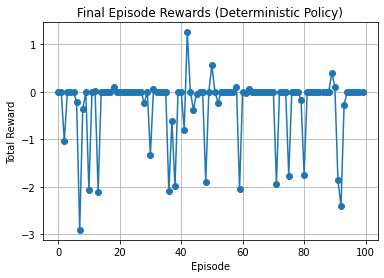

In [38]:
def evaluate_agent(env, model, n_episodes=5):
    """
    Runs n_episodes with a deterministic policy, returns a list of final rewards (floats).
    """
    rewards = []
    for ep in range(n_episodes):
        obs = env.reset()
        done = False
        ep_r = 0.0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            ep_r += reward[0]  # Because it's a DummyVecEnv (reward is array-like)
        rewards.append(ep_r)
    return rewards

# Evaluate the agent
episode_rewards = evaluate_agent(env, model, n_episodes=100)
print("Episode Rewards:", episode_rewards)

# Calculate % of rewards > 0
num_positive = sum(r > 0 for r in episode_rewards)
pct_positive = 100.0 * num_positive / len(episode_rewards)
print(f"Percentage of episodes with reward > 0: {pct_positive:.2f}%")

# Plot them
plt.figure()
plt.plot(episode_rewards, marker='o')
plt.title("Final Episode Rewards (Deterministic Policy)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()


Episode Rewards: [-0.01845484972000122, 0.0, 0.0, 0.044328153133392334, -2.039456009864807, 0.0, 0.0, -2.2903180718421936, 0.0, 0.0]


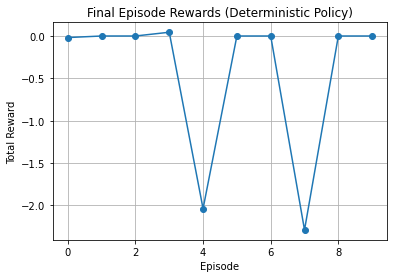

In [19]:
episode_rewards = evaluate_agent(env, model, n_episodes=10)
print("Episode Rewards:", episode_rewards)

# Plot them
plt.figure()
plt.plot(episode_rewards, marker='o')
plt.title("Final Episode Rewards (Deterministic Policy)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

In [25]:
def evaluate_agent_stepwise(env, model, n_episodes=1):
    """
    Returns a list (one element per episode), where each element is
    a list of the cumulative reward at each step of that episode.
    """
    stepwise_cum_rewards = []
    
    for ep in range(n_episodes):
        obs = env.reset()
        done = False
        ep_cum = 0.0
        ep_cum_list = []
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            
            # immediate reward is reward[0] because of DummyVecEnv
            immediate_r = reward[0]
            print(f"Step {len(ep_cum_list)}: immediate_r={immediate_r:.4f}")
            ep_cum += immediate_r
            ep_cum_list.append(ep_cum)
        
        stepwise_cum_rewards.append(ep_cum_list)
    
    return stepwise_cum_rewards


In [26]:
step_count = 0
obs = env.reset()
done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    step_count += 1
print("Episode had", step_count, "steps")


Episode had 5000 steps


Step 0: immediate_r=0.0069
Step 1: immediate_r=0.0122
Step 2: immediate_r=0.0022
Step 3: immediate_r=0.0130
Step 4: immediate_r=-0.0046
Step 5: immediate_r=0.0133
Step 6: immediate_r=-0.0007
Step 7: immediate_r=-0.0069
Step 8: immediate_r=0.0084
Step 9: immediate_r=0.0055
Step 10: immediate_r=0.0142
Step 11: immediate_r=0.0036
Step 12: immediate_r=0.0035
Step 13: immediate_r=-0.0177
Step 14: immediate_r=-0.0021
Step 15: immediate_r=-0.0053
Step 16: immediate_r=0.0065
Step 17: immediate_r=0.0200
Step 18: immediate_r=-0.0045
Step 19: immediate_r=-0.0063
Step 20: immediate_r=-0.0126
Step 21: immediate_r=0.0074
Step 22: immediate_r=0.0118
Step 23: immediate_r=0.0015
Step 24: immediate_r=0.0043
Step 25: immediate_r=-0.0050
Step 26: immediate_r=0.0115
Step 27: immediate_r=0.0061
Step 28: immediate_r=0.0167
Step 29: immediate_r=0.0093
Step 30: immediate_r=0.0032
Step 31: immediate_r=-0.0075
Step 32: immediate_r=-0.0055
Step 33: immediate_r=-0.0116
Step 34: immediate_r=0.0043
Step 35: immediat

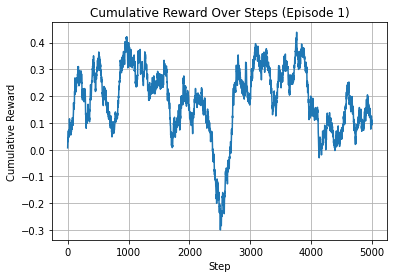

In [36]:
cumulative_rewards_per_episode = evaluate_agent_stepwise(env, model, n_episodes=1)
episode_cum = cumulative_rewards_per_episode[0]  # The first episode's list of stepwise cum rewards

import matplotlib.pyplot as plt

plt.figure()
plt.plot(episode_cum)
plt.title("Cumulative Reward Over Steps (Episode 1)")
plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv

# 1) Create the wide DataFrame
df_wide = create_wide_dataframe(data_url, limit_rows = 1000000)

# Optionally limit to the first 1000 rows for faster experiments:
#df_wide = df_wide.head(1000).copy()

# 2) Convert df_wide to adjacency matrices
rate_matrices, time_steps, currency_list = build_rate_matrices(df_wide)

# 3) Create an instance of your environment
env_instance = ForexTradingEnv(rate_matrices, currency_list, base_currency='USD')

# 4) Wrap the environment in a DummyVecEnv so SB3 can handle it
env = DummyVecEnv([lambda: env_instance])

# 5) Instantiate a DQN model
model = DQN(
    policy="MlpPolicy",    # Use a simple MLP
    env=env,
    learning_rate=1e-4,
    buffer_size=50000,
    batch_size=64,
    exploration_fraction=0.1,
    exploration_final_eps=0.02,
    verbose=1,
    #tensorboard_log="./dqn_fx_log"  # optional, for TensorBoard
)

# 6) Train the model
model.learn(total_timesteps=200000)  # adjust as needed

# 7) Evaluate or test the trained model
obs = env.reset()
done = False
total_reward = 0.0

while True:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    total_reward += reward[0]  # stable-baselines uses vectorized env, so reward is array-like
    if done:
        break

print("Total reward (deterministic) after training:", total_reward)


/Users/benjaminzaidel/opt/anaconda3/envs/ALL_PYTHON/lib/python3.8/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


Using cpu device
[DEBUG] final portfolio: [0.         0.         0.         0.         0.         0.
 0.         0.         0.21967697], final_val_base=0.0000
[DEBUG] final reward=-1.0000
[DEBUG] final portfolio: [0.        1.5005842 0.        0.        0.        0.        0.
 0.        0.       ], final_val_base=1.0031
[DEBUG] final reward=0.0031
[DEBUG] final portfolio: [0.        0.        0.        0.        0.        0.        0.
 1.0059167 0.       ], final_val_base=1.0059
[DEBUG] final reward=0.0059
[DEBUG] final portfolio: [0.        0.        0.        0.        0.        0.        0.
 0.9853067 0.       ], final_val_base=0.9853
[DEBUG] final reward=-0.0147
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.608    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1503     |
|    time_elapsed     | 5        |
|    total_timesteps  | 8000     |
| train/              |          |
|    learn

In [53]:
from stable_baselines3.common.evaluation import evaluate_policy

# Suppose 'model' is your trained DQN and 'env' is your DummyVecEnv
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=5, render=False)

print(f"Evaluation over 5 episodes: mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")


/Users/benjaminzaidel/opt/anaconda3/envs/ALL_PYTHON/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Evaluation over 5 episodes: mean_reward=-2.00 +/- 0.00


[DEBUG] final portfolio: [0.         0.         0.         0.         0.67279744 0.
 0.         0.         0.        ], final_val_base=1.0105
[DEBUG] final reward=0.0105
[DEBUG] final portfolio: [0.        0.        0.        0.        0.        0.        0.
 0.9999781 0.       ], final_val_base=1.0000
[DEBUG] final reward=-0.0000
[DEBUG] final portfolio: [0.       0.       0.       0.       0.       0.       0.       1.007399
 0.      ], final_val_base=1.0074
[DEBUG] final reward=0.0074
[DEBUG] final portfolio: [0.       0.       0.       1.063646 0.       0.       0.       0.
 0.      ], final_val_base=0.0000
[DEBUG] final reward=-1.0000
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.608    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1358     |
|    time_elapsed     | 5        |
|    total_timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.0001   |
| 

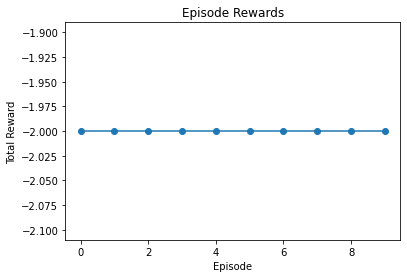

[DEBUG] final portfolio: [0.        0.        0.        1.0778773 0.        0.        0.
 0.        0.       ], final_val_base=0.0000
[DEBUG] final reward=-1.0000
Final single-episode reward: -2.0


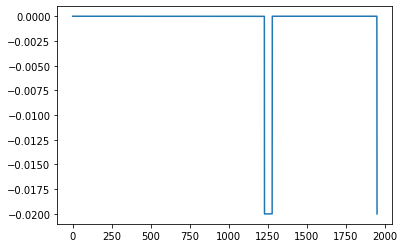

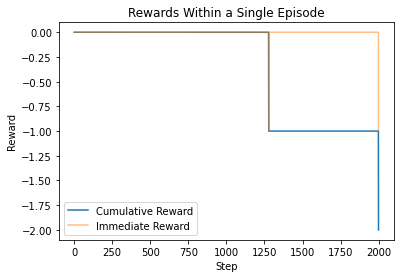

In [80]:
import matplotlib.pyplot as plt

def evaluate_agent(env, model, n_episodes=10):
    """
    Runs n_episodes in a row, records final rewards,
    returns a list of total rewards for each episode.
    """
    rewards = []
    for ep in range(n_episodes):
        obs = env.reset()
        done = False
        total_r = 0.0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            # reward is array-like for DummyVecEnv
            total_r += reward[0]
        rewards.append(total_r)
    return rewards

def run_single_episode(env, model):
    obs = env.reset()
    done = False
    step_rewards = []
    cum_rewards = []
    total_r = 0.0
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        step_r = reward[0]  # for vectorized env
        total_r += step_r
        step_rewards.append(step_r)
        cum_rewards.append(total_r)
    
    return step_rewards, cum_rewards, total_r


# 1) Train
model.learn(total_timesteps=200000)

# 2) Evaluate on 10 episodes
episode_rewards = evaluate_agent(env, model, n_episodes=10)
plt.figure()
plt.plot(episode_rewards, marker='o')
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

# 3) Single-episode breakdown
step_rewards, cum_rewards, final_r = run_single_episode(env, model)
print("Final single-episode reward:", final_r)
window_size = 50
smoothed_immediate = np.convolve(step_rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(smoothed_immediate, label='Smoothed Immediate Reward')
plt.figure()
plt.plot(cum_rewards, label="Cumulative Reward")
plt.plot(step_rewards, label="Immediate Reward", alpha=0.5)
plt.title("Rewards Within a Single Episode")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.legend()
plt.show()
